[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/cako/cuda-by-numba-examples/blob/main/CUDA_by_Numba_Examples_4_of_4.ipynb)

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/cako/cuda-by-numba-examples/main?filepath=CUDA_by_Numba_Examples_4_of_4.ipynb)

<center>
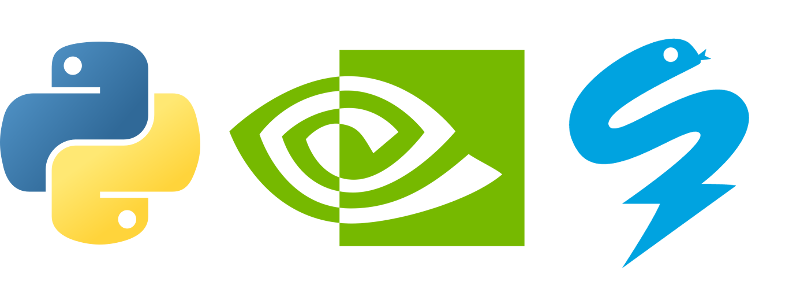
</center>

<h1><center>CUDA by Numba Examples</center></h1>
<h2><center>Part 4 of 4: Atomics and Mutexes</center></h2>
<h3><center>Carlos Costa (<a href="https://github.com/cako">@cako</a>)</center></h3>
<h4><center>September 2022</center></h4>

<hr>

<h3>Introduction</h3>

In the first three installments of this series, we've gone through most of the basics of CUDA development such as launching kernels to perform embarassingly parallel tasks, leveraging shared memory to perform fast reductions, encapsulating reusable logic as device functions, and how to use events and streams to organize and control kernel execution.

<br>
<h3>In This Tutorial</h3>

In the last installment of this series, we will tackle atomic instructions which will allow us to safely operate on the same memory from multiple threads. We will also learn how to leverage these operations to create a <i><a href="https://en.wikipedia.org/wiki/Lock_(computer_science)">mutex</a></i>, a coding pattern that allows us to "lock" a certain resource so it is only used by one thread at a time.

New in this tutorial:
* <code>numba.cuda.atomic.add</code>
* <code>numba.cuda.atomic.compare_and_swap</code>
* <code>numba.cuda.atomic.exch</code>
* <code>numba.cuda.threadfence</code>

<a href="https://github.com/cako/cuda-by-numba-examples/blob/main/CUDA_by_Numba_Examples_1_of_4.ipynb">Part 1</a>,
<a href="https://github.com/cako/cuda-by-numba-examples/blob/main/CUDA_by_Numba_Examples_2_of_4.ipynb">Part 2</a>
<a href="https://github.com/cako/cuda-by-numba-examples/blob/main/CUDA_by_Numba_Examples_3_of_4.ipynb">Part 3</a>
<a href="https://github.com/cako/cuda-by-numba-examples/blob/main/CUDA_by_Numba_Examples_4_of_4.ipynb">Part 4 (this part)</a>
</center>


---

In [ ]:
!pip install --upgrade numba matplotlib>=3.5

In [ ]:
import warnings
from datetime import datetime
from time import perf_counter

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import requests

import numba
from numba import cuda
from numba.core.errors import NumbaPerformanceWarning
from tqdm.auto import trange

print(np.__version__)
print(numba.__version__)
print(mpl.__version__)

# Ignore NumbaPerformanceWarning
warnings.simplefilter("ignore", category=NumbaPerformanceWarning)

1.21.6
0.56.2
3.5.3


In [ ]:
cuda.detect()

Found 1 CUDA devices
id 0             b'Tesla T4'                              [SUPPORTED]
                      Compute Capability: 7.5
                           PCI Device ID: 4
                              PCI Bus ID: 0
                                    UUID: GPU-f8e416c2-139a-4b7d-174a-c3df5393f2cc
                                Watchdog: Disabled
             FP32/FP64 Performance Ratio: 32
Summary:
	1/1 devices are supported


True

## Atomics

GPU programming is entirely based on parallelizing the same instructions as much as possible. For many "embarrassingly parallel" tasks, threads don't need to cooperate or use resources that are used by other threads. Other patterns, such as reductions ensure through the design of the algorithm that the same resource is only ever used by a subset of threads. In those cases, we ensured that all other threads were kept up to date through the use of ``syncthreads``.

Some cases occur where many threads must read and write to the same array. This can cause issues when either the read or the write is tried to be performed at the same time. Suppose we have a kernel which increments a single value by one.

In [ ]:
# Example 4.1: A data race condition.
@cuda.jit
def add_one(x):
    x[0] = x[0] + 1

When we launch this kernel with a single block of a thread, we will get a value of 1 stored in the input array.

In [ ]:
dev_val = cuda.to_device(np.zeros((1,)))

add_one[1, 1](dev_val)
dev_val.copy_to_host()

array([1.])

Now, what happens when we launch 10 blocks of 16 threads each? We are summing a total of 10 × 16 × 1 to the same memory element, so we should hope to get a value of 160 stored in `dev_val`. Right? 

In [ ]:
dev_val = cuda.to_device(np.zeros((1,)))

add_one[10, 16](dev_val)
dev_val.copy_to_host()

array([1.])

In reality we are very unlikely to ever reach 160 stored at `dev_val`. Why? Because threads are reading and writing to the same memory variable at the same time!

Below is a schematic of what may happen when four threads are attempting to read and write from the same global memory. Threads 1-3 read the same value of 0 from the global register a different times (t=0, 2, 2, respectively). They all increment by 1 and write back to global memory at times t=4, 7 and 8. Thread 4 starts a little later than the rest, at t=5. At this time, Thread 1 has already written to global memory, so Thread 4 reads the value of 1. It will eventually overwrite the global variable to 2 at t=12.

<br>

<center>
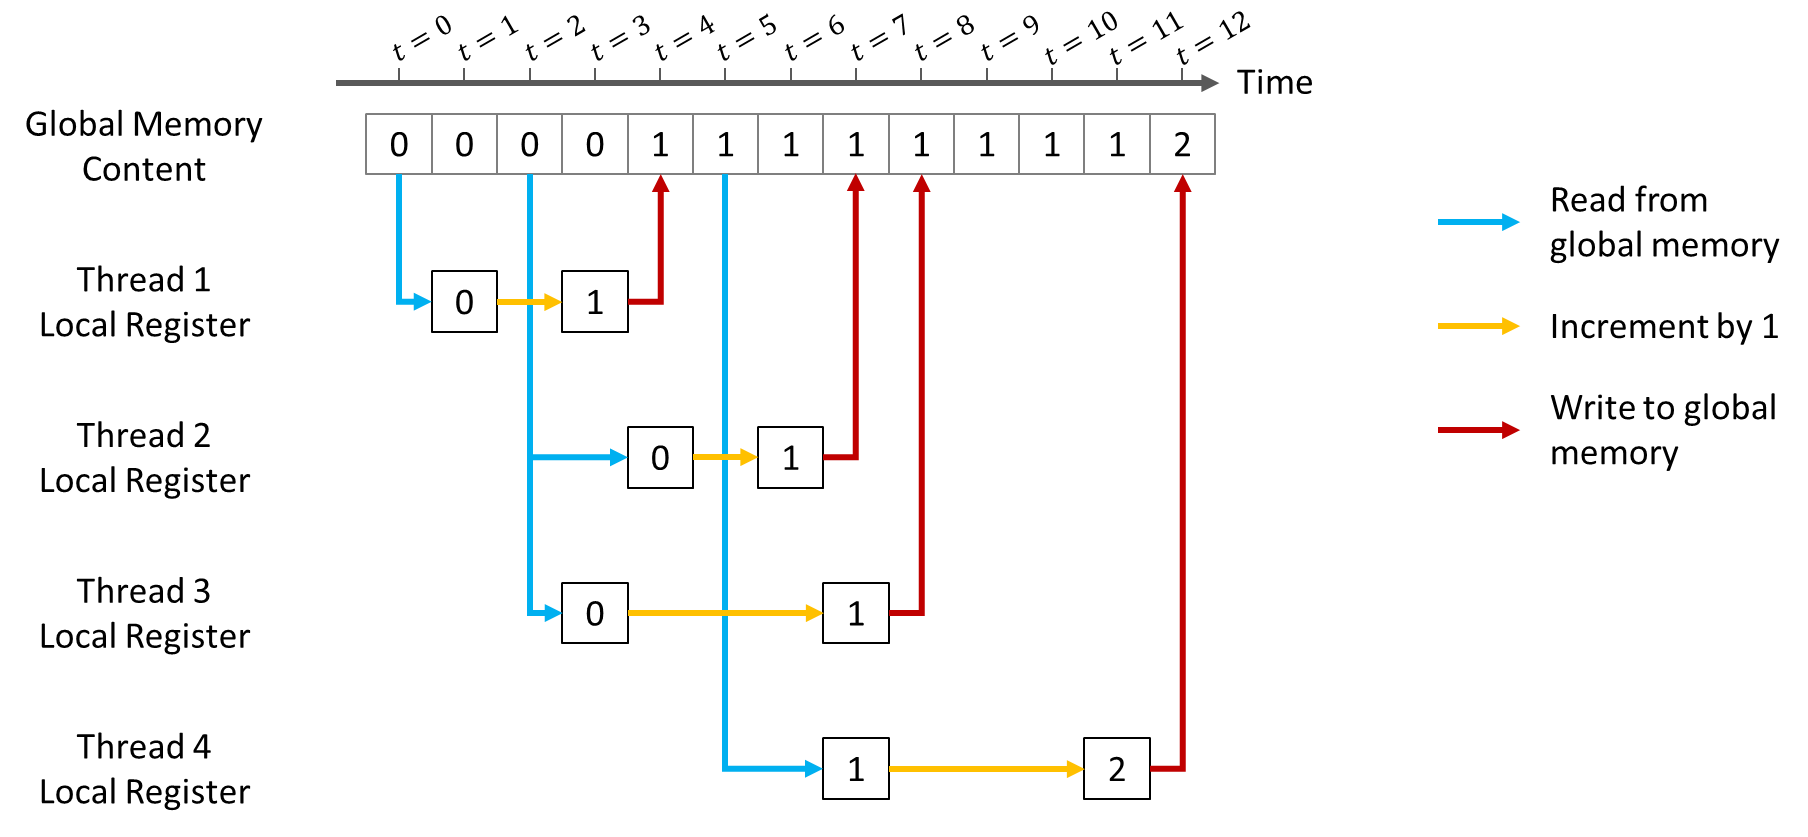
<p>Figure 4.1. Several threads trying to read and write from the same global memory may result in a <a href="https://en.wikipedia.org/wiki/Race_condition#Computing">race condition</a>. Credit: own work.</p>
</center>
<br>
<center>
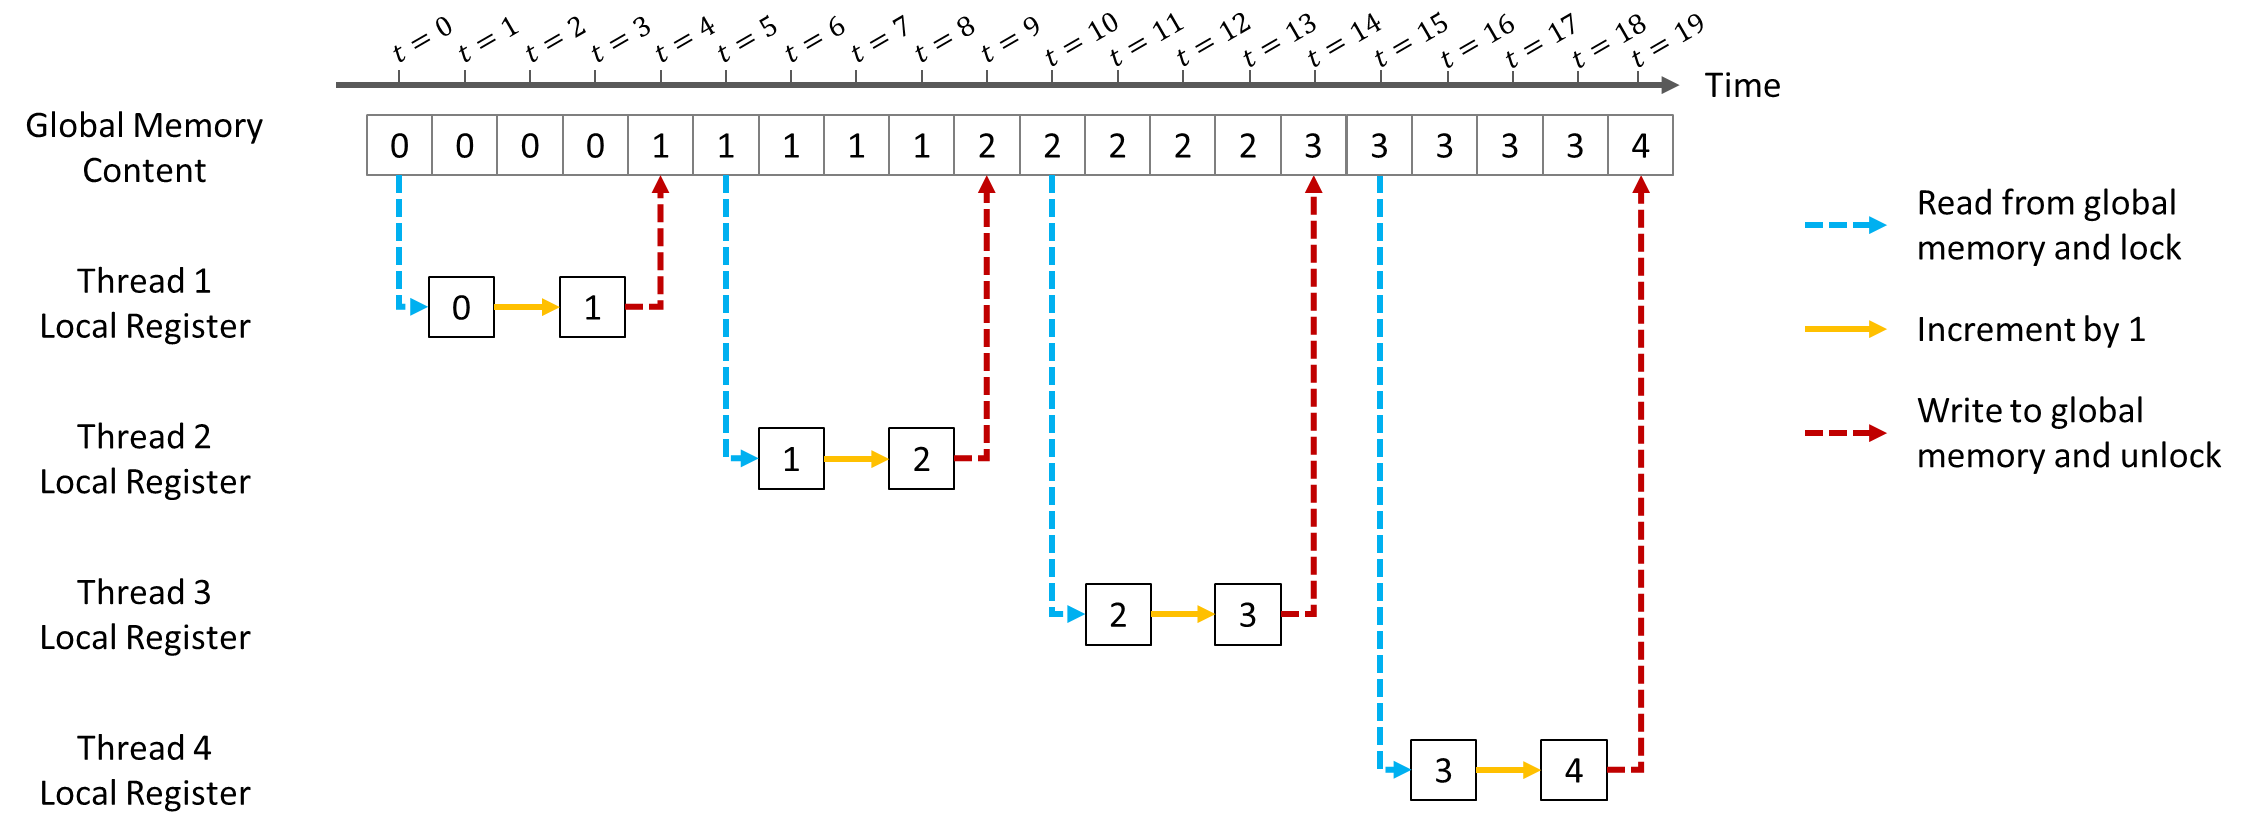
<p>Figure 4.2. When the resource is locked from read/write while the thread is operating on the contents, we ensure that each thread gets an updated value upon read, and its write are seen by the other threads. Atomic operations are generally slower. Credits: own work.</p>
</center>


If we want to obtain the result we originally expected (as depicted in Figure 4.2), we should substitute our non-atomic addition operation for an atomic operation.

In [ ]:
# Example 4.2: An atomic add without race conditions.
@cuda.jit
def add_one_atomic(x):
    cuda.atomic.add(x, 0, 1)  # Arguments are array, array index, value to add


dev_val = cuda.to_device(np.zeros((1,)))

add_one_atomic[10, 16](dev_val)
dev_val.copy_to_host()

array([160.])

### Atomic Add: Computing a Histogram

To better comprehend where and how to use atomics, we will use histogram computation. Suppose one wants to count how many of each letter of the alphabet is in a certain text. A simple algorithm to achieve this is to create a 26 "buckets", each corresponding to a letter of the English alphabet. We would then iterate through the letters of the text, and whenever we encounter an "a", we would increment the first bucket by one, whenever we encounter a "b", we would increment the second bucket by one, and so on and so forth.

In standard Python, these "buckets" could be dictionaries, each linking a letter to a number. Since we are like to operate on arrays GPU programming, we will use an array instead. And instead of bucketing 26 letters, we will bucket all 128 [ASCII](https://en.wikipedia.org/wiki/ASCII) characters.

Before we do that, we need to convert our strings to an array of "numbers". In this case, it makes sense to convert UTF-8 strings to the `uint8` datatype.

In [ ]:
def str_to_array(x):
    return np.frombuffer(bytes(x, "utf-8"), dtype=np.uint8)

In [ ]:
my_str = "CUDA by Numba Examples"
my_str_array = str_to_array(my_str)
my_str_array

array([ 67,  85,  68,  65,  32,  98, 121,  32,  78, 117, 109,  98,  97,
        32,  69, 120,  97, 109, 112, 108, 101, 115], dtype=uint8)

Note that the lowercase and uppercase letters have a different code. So we will use a couple of utility functions to select only lowercase or only uppercase letters.

In [ ]:
def grab_uppercase(x):
    return x[65 : 65 + 26]


def grab_lowercase(x):
    return x[97 : 97 + 26]

Numpy already provides a histogram function, which we will use to both verify our results, but also compare runtime.

In [ ]:
histo_np, bin_edges = np.histogram(my_str_array, bins=128, range=(0, 128))

np.testing.assert_allclose(bin_edges, np.arange(129))  # Bin edges are 1 more than bins

In [ ]:
def plot_letter_histogram(hist, bin_edges, kind="percent", ax=None):
    width = 0.8
    start = bin_edges[0]
    stop = bin_edges[0] + hist.shape[0]

    if ax is None:
        ax = plt.gca()
    ax.bar(np.arange(start, stop), hist, width=width)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{int(x):c}"))
    ax.set(xlim=[start - width, stop - 1 + width], ylabel=kind.title())
    if kind == "count":
        ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{x:.0f}"))
    else:
        sum_hist = hist.sum()
        if kind == "probability":
            ax.yaxis.set_major_formatter(
                ticker.FuncFormatter(lambda x, pos: f"{x/sum_hist:.2f}")
            )
        else:
            ax.yaxis.set_major_formatter(
                ticker.FuncFormatter(lambda x, pos: f"{x/sum_hist:.0%}")
            )

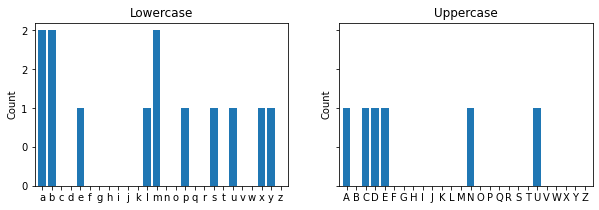

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3), sharey=True)
plot_letter_histogram(
    grab_lowercase(histo_np), grab_lowercase(bin_edges), kind="count", ax=axs[0]
)
plot_letter_histogram(
    grab_uppercase(histo_np), grab_uppercase(bin_edges), kind="count", ax=axs[1]
)
axs[0].set(title="Lowercase")
axs[1].set(title="Uppercase");

Let's write our own CPU version of the function to understand the mechanics.

In [ ]:
def histogram_cpu(arr):
    histo = np.zeros(128, dtype=np.int64)
    for char in arr:
        if char < 128:
            histo[char] += 1
    return histo

In [ ]:
histo_cpu = histogram_cpu(my_str_array)

assert (histo_cpu - histo_np).sum() == 0  # Matches numpy version

Since each ASCII character is mapped to a bin in the 128-element array, all we need to do is find its bin and increment by 1, as long as that bin is within 0 and 127 (including).

We are ready for our first GPU version.

In [ ]:
# Example 4.3: A GPU histogram
@cuda.jit
def kernel_histogram(arr, histo):
    i = cuda.grid(1)
    threads_per_grid = cuda.gridsize(1)

    for iarr in range(i, arr.size, threads_per_grid):
        if arr[iarr] < 128:
            cuda.atomic.add(histo, arr[iarr], 1)


@cuda.jit
def kernel_zero_init(arr):
    i = cuda.grid(1)
    threads_per_grid = cuda.gridsize(1)
    for iarr in range(i, arr.size, threads_per_grid):
        arr[iarr] = 0

In [ ]:
threads_per_block = 128
blocks_per_grid = 32

In [ ]:
my_str_array_gpu = cuda.to_device(my_str_array)
histo_gpu = cuda.device_array((128,), dtype=np.int64)

kernel_zero_init[1, 128](histo_gpu)
kernel_histogram[blocks_per_grid, threads_per_block](my_str_array_gpu, histo_gpu)
histo_cuda = histo_gpu.copy_to_host()
assert (histo_cuda - histo_cpu).sum() == 0

Cool! So at least our function is working. Let's up the ante and apply this to a larger dataset.

In [ ]:
# Get the complete works of William Shakespeare
URL = "https://www.gutenberg.org/cache/epub/100/pg100.txt"
response = requests.get(URL)
str_bill = response.text
print(str_bill.split("\r")[0])

The Project Gutenberg eBook of The Complete Works of William Shakespeare, by William Shakespeare


In [ ]:
str_bill_array = np.frombuffer(bytes(str_bill, "utf-8"), dtype=np.uint8)
str_bill_array.size

5757359

That's about 5.7 million characters which we will be processing. Let's run and clock our three versions so far.

In [ ]:
histo_bill_np, _ = np.histogram(str_bill_array, bins=128, range=(0, 128))

In [ ]:
niter = 10
elapsed_np = 0.0
for i in trange(niter):
    tic = perf_counter()
    np.histogram(str_bill_array, bins=128, range=(0, 128))
    toc = perf_counter()
    elapsed_np += 1e3 * (toc - tic)  # Convert to ms
elapsed_np /= niter

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
niter = 2  # very slow!
elapsed_cpu = 0.0
for i in trange(niter):
    tic = perf_counter()
    histogram_cpu(str_bill_array)
    toc = perf_counter()
    elapsed_cpu += 1e3 * (toc - tic)  # in ms
elapsed_cpu /= niter

  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
class CUDATimer:
    def __init__(self, stream):
        self.stream = stream
        self.elapsed = None  # in ms

    def __enter__(self):
        self.event_beg = cuda.event()
        self.event_end = cuda.event()
        self.event_beg.record(stream=self.stream)
        return self

    def __exit__(self, type, value, traceback):
        self.event_end.record(stream=self.stream)
        self.event_end.wait(stream=self.stream)
        self.event_end.synchronize()
        self.elapsed = self.event_beg.elapsed_time(self.event_end)

In [ ]:
threads_per_block = 128
blocks_per_grid = 32 * 80

In [ ]:
str_bill_array_gpu = cuda.to_device(str_bill_array)
histo_gpu = cuda.device_array((128,), dtype=np.int64)

stream = cuda.stream()

niter = 100
elapsed_gpu = 0.0
for i in trange(niter):
    kernel_zero_init[1, 128, stream](histo_gpu)
    with CUDATimer(stream=stream) as ct:
        kernel_histogram[blocks_per_grid, threads_per_block, stream](
            str_bill_array_gpu, histo_gpu
        )
    elapsed_gpu += ct.elapsed
elapsed_gpu /= niter
cuda.synchronize()

  0%|          | 0/100 [00:00<?, ?it/s]

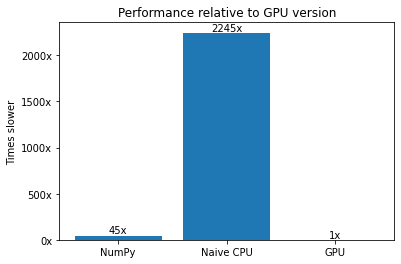

In [ ]:
fig, ax = plt.subplots()
rects = ax.bar(
    ["NumPy", "Naive CPU", "GPU"],
    [elapsed_np / elapsed_gpu, elapsed_cpu / elapsed_gpu, elapsed_gpu / elapsed_gpu],
)
ax.bar_label(rects, padding=0, fmt="%.0fx")
ax.set(title="Performance relative to GPU version", ylabel="Times slower")
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0f}x"))

Taking our GPU version as baseline, we see that the NumPy version is at least 40x slower and our naive CPU version is thousands of times slower. We can process this 5.7 million character dataset in few milliseconds, whereas out naive CPU solution takes more than 10 seconds. This means that we could potentially process a 5 billion character dataset (if we had a GPU with more than 20 Gb RAM) in few seconds, whereas that would take over an hour with our slowest version. So we're already doing pretty well already!

Can we improve it? Well, let's revisit the memory access pattern of this kernel.
```python
...
for iarr in range(i, arr.size, threads_per_grid):
    if arr[iarr] < 128:
        cuda.atomic.add(histo, arr[iarr], 1)
```
`histo` is an 128-element array sitting in the global memory of the GPU. Each thread launched at any one point is trying to access some element of this array (namely, element `arr[iarr]`). So at any one point, we have about `threads_per_block * blocks_per_grid` = 128 × 32 × 80 = 327,680 threads trying to access 128 elements. So we have on average about 32 × 80 = 2,560 threads competing for the same global memory address.

To mitigate this, we are compute local histograms in shared memory array. This is because
1. Shared arrays sits on-chip, so has much faster reads/writes
2. Shared arrays are local to each thread block, so fewer threads can access and therefore compete for its resources.

---
$\color{Goldenrod}{\textbf{INFO}}$

Our calculations assume that characters are uniformly distributed. Be careful with these assumptions as natural datasets may not conform to them. For example, most characters in natural language text are lowercase letters, instead of 2,560 threads competing on average, we'll have 128 × 32 × 80 ÷ 26 ≈ 12,603 threads competing.

---

In [ ]:
# Example 4.4: A GPU histogram without as many memory conflicts
@cuda.jit
def kernel_histogram_shared(arr, histo):
    # Create shared array to hold local histogram
    histo_local = cuda.shared.array((128,), numba.int64)
    histo_local[cuda.threadIdx.x] = 0  # initialize to zero
    cuda.syncthreads()  # ensure all threads in the same block "registered" the initialization

    i = cuda.grid(1)
    threads_per_grid = cuda.gridsize(1)

    for iarr in range(i, arr.size, threads_per_grid):
        if arr[iarr] < 128:
            cuda.atomic.add(
                histo_local, arr[iarr], 1
            )  # fewer threads competing for the same memory

    # Ensure all threads in the block are up to date
    cuda.syncthreads()
    # Update global memory histogram with values from local histograms
    cuda.atomic.add(histo, cuda.threadIdx.x, histo_local[cuda.threadIdx.x])

Whereas before we had 2,560 threads competing for the same memory, now we have 2,560 ÷ 128 = 20 threads. At the end, we need to sum all the local results. Since there are 32 × 80 = 2,560 blocks, that means there are 2,560 competing trying to write to global memory. However, we ensured that this is done only once, whereas before we had to do this until we exhausted all elements of the input array.

Let's see how this new version fares in comparison!

In [ ]:
str_bill_array_gpu = cuda.to_device(str_bill_array)

niter = 100
elapsed_gpu_shared = 0.0
for i in trange(niter):
    kernel_zero_init[1, 128, stream](histo_gpu)
    cuda.synchronize()
    with CUDATimer(stream=stream) as ct:
        kernel_histogram_shared[blocks_per_grid, threads_per_block, stream](
            str_bill_array_gpu, histo_gpu
        )
    elapsed_gpu_shared += ct.elapsed
elapsed_gpu_shared /= niter
cuda.synchronize()

  0%|          | 0/100 [00:00<?, ?it/s]

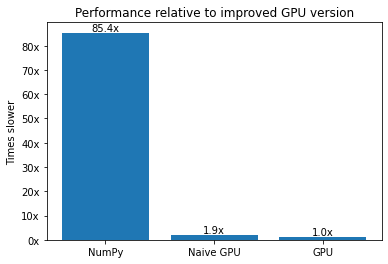

In [ ]:
fig, ax = plt.subplots()
rects = ax.bar(
    ["NumPy", "Naive GPU", "GPU"],
    [
        elapsed_np / elapsed_gpu_shared,
        elapsed_gpu / elapsed_gpu_shared,
        elapsed_gpu_shared / elapsed_gpu_shared,
    ],
)
ax.bar_label(rects, padding=0, fmt="%.1fx")
ax.set(title="Performance relative to improved GPU version", ylabel="Times slower")
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0f}x"))

So thats a ~3x improvement over the naïve version!

We set the number of blocks to be a multiple of 32 * number of SMs, as suggested in the previous tutorial. Now we want to know exactly how many. Let's time it!

In [ ]:
threads_per_block = 128
elapsed_conflict = []
elapsed_shared = []

block_range = range(10, 1000, 5)
histo_gpu = cuda.device_array((128,), np.int64, stream=stream)
for i in trange(block_range.start, block_range.stop, block_range.step):
    blocks_per_grid = 32 * i

    elapsed1 = 0.0
    elapsed2 = 0.0
    niter = 50
    for i in range(niter):
        kernel_zero_init[1, 128, stream](histo_gpu)
        with CUDATimer(stream) as ct1:
            kernel_histogram[blocks_per_grid, threads_per_block, stream](
                str_bill_array_gpu, histo_gpu
            )
        elapsed1 += ct1.elapsed

        kernel_zero_init[1, 128, stream](histo_gpu)
        with CUDATimer(stream) as ct2:
            kernel_histogram_shared[blocks_per_grid, threads_per_block, stream](
                str_bill_array_gpu, histo_gpu
            )
        elapsed2 += ct2.elapsed

    elapsed_conflict.append(elapsed1 / niter)
    elapsed_shared.append(elapsed2 / niter)

  0%|          | 0/198 [00:00<?, ?it/s]

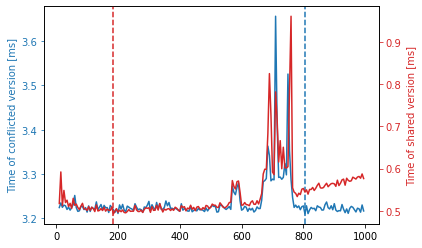

In [ ]:
fastest_sm_conflict = list(block_range)[np.argmin(elapsed_conflict)]
fastest_sm_shared = list(block_range)[np.argmin(elapsed_shared)]

fig, ax = plt.subplots()
ax.plot(block_range, elapsed_conflict, color="C0")
ax.axvline(fastest_sm_conflict, ls="--", color="C0")
ax.yaxis.label.set_color("C0")
ax.tick_params(axis="y", colors="C0")
ax.set(ylabel="Time of conflicted version [ms]")

ax2 = ax.twinx()
ax2.plot(block_range, elapsed_shared, color="C3")
ax2.axvline(fastest_sm_shared, ls="--", color="C3")
ax2.yaxis.label.set_color("C3")
ax2.tick_params(axis="y", colors="C3")
ax2.set(ylabel="Time of shared version [ms]");

Two things: first, we need two axes to display the data since the naive version is so much slower.
Second, the vertical lines show how many SMs are optimal for a certain function.
Lastly, whereas the naive version does not get worse as more blocks are added, the same is not true for the shared version. To understand why that is, remember that the shared array version has two parts

* The first part with few threads competing for the same (fast) memory (the shared array part).
* The second part with many threads competing for the same (slow) memory (the final atomic add).

As more blocks are added, in the naive version it soon hits its bottleneck that cannot be made worse, whereas in the shared array version, the competition remains the same in the first part, but *increases* in the second part. On the other hand, too few blocks don't generate enough parallelization (for either version). The graph above finds the "sweet spot" between these two extremes.

### Locking resources with a mutex

In the previous examples we used atomic add operations with integer values to lock certain resources and ensure that only one thread at a time controlled them. Addition is not the only atomic operation, and it need not be applied to integer values. Numba CUDA supports [a variety of atomic operations on ints and floats](https://numba.readthedocs.io/en/stable/cuda/intrinsics.html). But once upon a time (CUDA compute 1.x), float atomics didn't exist. So if we wanted to write a reduction using atomics for floats, we would have required another structure.

While nowadays atomics do support floats, the "mutex" code pattern which allows us to apply arbitrary atomic operations can still be useful in some situations.

A mutex, that is, mutual exclusion, is a way of signalling that some resource is available or not. A mutex can be created with a variable that can take two values:
* **0**: 🟢 Green light, proceed with using a certain memory/resource
* **1**: 🔴 Red light, stop, do not attempt to use/access a certain memory/resource

To lock the memory, one should write 1 to the mutex, to unlock it, one should write 0. But one needs to be careful, if one writes (unatomically) to the mutex, other threads may be currently accessing that resource, creating at minimum the wrong values, or even worse, creating a deadlock. Another issue is a mutex can only be locked if it has not been previously locked. So prior to writing a 1 (to lock) we need to read the mutex and ensure it is 0 (unlocked). CUDA provides a special operation to do both of these things atomically: atomicCAS. In Numba CUDA, it is more clearly named:

```python
cuda.atomic.compare_and_swap(array, old, val)
```

This function will only assign `val` to the `array[0]` (atomically) if the current value at `array[0]` is equal to `old`. It also returns the current value of `array[0]`, atomically. To lock a mutex, we could therefore apply it with

```python
cuda.atomic.compare_and_swap(mutex, 0, 1)
```

whereby we will assign a lock (1) only when it is unlocked (0). One issue with the above line is that if the thread reaches it and reads a 1 (locked) it simply carries on, which likely is not what we want. We would ideally like the thread to stop until we can lock the mutex. So instead, we do the following:

```python
while cuda.atomic.compare_and_swap(mutex, 0, 1) != 0:
    pass
```

In this case, the thread will persist until it can properly lock the thread. Suppose the thread reaches a previously locked mutex. Its current value is 1. So we first notice that `compare_and_swap` will *not* be able to lock it since `curr = 1 != old = 0`. It also won't exit the `while` since the current value 1 is different from 0 (the `while` condition). It will remain in this loop until it is finally able to read an unlocked mutex whose current value is 0. In this case, it will also be able to assign 1 to the mutex since `curr = 0 == old = 0`.

To unlock, we just need to assign a 0 atomically to the mutex. We will use

```python
cuda.atomic.exch(array, idx, val)
```

Which simply assigns `array[idx] = val` atomically, returning the old value of `array[idx]` (loaded atomically). Since we won't use the return value of this function, for us it acts simply as an atomic assignment.

Now that we have a lock and unlock mechanism, let's retry the atomic "add one" but using a mutex instead.

In [ ]:
# Example 4.5: An atomic add with mutex.
@cuda.jit(device=True)
def lock(mutex):
    while cuda.atomic.compare_and_swap(mutex, 0, 1) != 0:
        pass
    cuda.threadfence()


@cuda.jit(device=True)
def unlock(mutex):
    cuda.threadfence()
    cuda.atomic.exch(mutex, 0, 0)


@cuda.jit
def add_one_mutex(x, mutex):
    lock(mutex)  # Threads will stall here until they can atomically read 0 from
                 # the mutex, at which point they will atomically write a 1 to it
    
    x[0] += 1  # Only a single thread will access this resource at a time, all
               # others will be waiting in the line above

    unlock(mutex)  # The thread atomically writes a 0 to the mutex, releasing it
                   # all other threads are trying to obtain the lock

In [ ]:
dev_val = cuda.to_device(np.zeros((1,)))
mutex = cuda.to_device(np.zeros((1,), dtype=np.int64))

add_one_mutex[10, 16](dev_val, mutex)
dev_val.copy_to_host()

array([160.])

The code above is fairly straight forward, we have a kernel which locks execution of the threads until they can themselves can get an unlocked mutex. At that point, they will update the value of `x[0]` and unlock the mutex. At no point will `x[0]` be read or written by more than one thread, this achieving atomicity!

There is only one detail we haven't covered in the above code, the use of `cuda.threadfence()`. It is not required for this example, but ensure the correctness of the lock and unlock mechanism. We will see why soon!

### A mutexed dot product

In tutorial 2, we learned how to apply reductions in the GPU. We used them to compute the sum of an array. One of the inelegant aspects of our code was that we left some of this summation to the CPU. What we lacked at the time was the ability to apply atomic operations.

We reinterpret that example as a dot product, but this time follow the summation through to the end. That means that we won't return a "partial" dot product, but will use atomic summation in the GPU through the use of a mutex. Let's first reinterpret our reduce as a dot product:

In [ ]:
threads_per_block = 256
blocks_per_grid = 32 * 20

In [ ]:
# Example 4.6: A partial dot product
@cuda.jit
def dot_partial(a, b, partial_c):
    igrid = cuda.grid(1)
    threads_per_grid = cuda.gridsize(1)
    s_thread = 0.0
    for iarr in range(igrid, a.size, threads_per_grid):
        s_thread += a[iarr] * b[iarr]

    s_block = cuda.shared.array((threads_per_block,), numba.float32)
    tid = cuda.threadIdx.x
    s_block[tid] = s_thread

    cuda.syncthreads()

    i = cuda.blockDim.x // 2
    while i > 0:
        if tid < i:
            s_block[tid] += s_block[tid + i]
        cuda.syncthreads()
        i //= 2

    # Above this line, the code will remain exactly the same in the next version
    if tid == 0:
        partial_c[cuda.blockIdx.x] = s_block[0]

In [ ]:
# Example 4.6: A full dot product with mutex
@cuda.jit
def dot_mutex(mutex, a, b, c):
    igrid = cuda.grid(1)
    threads_per_grid = cuda.gridsize(1)
    s_thread = 0.0
    for iarr in range(igrid, a.size, threads_per_grid):
        s_thread += a[iarr] * b[iarr]

    s_block = cuda.shared.array((threads_per_block,), numba.float32)
    tid = cuda.threadIdx.x
    s_block[tid] = s_thread

    cuda.syncthreads()

    i = cuda.blockDim.x // 2
    while i > 0:
        if tid < i:
            s_block[tid] += s_block[tid + 1]
        cuda.syncthreads()
        i //= 2

    # Instead of assigning the partial reduction to a global memory array, we
    # will atomically add it to c[0].
    if tid == 0:
        lock(mutex)
        c[0] += s_block[0]
        unlock(mutex)

In [ ]:
N = 10_000_000
a = np.ones(N, dtype=np.float32)
b = (np.ones(N) / N).astype(np.float32)

dev_a = cuda.to_device(a)
dev_b = cuda.to_device(b)
dev_c = cuda.device_array((1,), dtype=a.dtype)
dev_partial_c = cuda.device_array((blocks_per_grid,), dtype=a.dtype)
dev_mutex = cuda.device_array((1,), dtype=np.int32)

In [ ]:
dot_partial[blocks_per_grid, threads_per_block](dev_a, dev_b, dev_partial_c)
dev_partial_c.copy_to_host().sum()

0.9999999

In [ ]:
kernel_zero_init[1, 1](dev_c)
dot_mutex[blocks_per_grid, threads_per_block](dev_mutex, dev_a, dev_b, dev_c)
dev_c.copy_to_host().item()

1.0000089406967163

Everything checks out!

We promised we would revisit `cuda.threadfence`. From the CUDA "bible" ([B.5. Memory Fence Functions](https://docs.nvidia.com/cuda/cuda-c-programming-guide/index.html#memory-fence-functions)): *ensures that no writes to all memory made by the calling thread after the call to __threadfence() are observed by any thread in the device as occurring before any write to all memory made by the calling thread before the call to __threadfence().*

If we omit threadfencing before unlocking the mutex, we might be reading stale information *even when using atomic operations*, since memory may not be yet written by other threads. Similarly, before unlocking, we must ensure that we update the memory references. None of this is at all obvious, and was first raised in [Alglave et al. 2015](https://johnwickerson.github.io/papers/gpuconcurrency.pdf), and subsequently published in the Errata of CUDA by Examples which inspired this series of tutorials.

# Epilogue

In the four instalments of this series, we covered enough ground to allow you to use Numba CUDA in a variety of common situations. By no means exhaustive, these tutorials were intended to introduce and pique the interest of the reader in CUDA programming.

Some of the topics we have not covered are: dynamic parallelism (letting kernels launch kernels), complex synchronization (e.g., warp-level, cooperative groups), complex memory fencing (which we touched upon above), multi-GPU, textures, and many other topics. Some of these are not currently supported by Numba CUDA (as of version 0.56), and some of them were considered too advanced techniques for an introductory tutorial.

To further improve your CUDA skills, the [CUDA C++ Programming Guide](https://docs.nvidia.com/cuda/cuda-c-programming-guide/index.html) is highly recommended, as well as the [Nvidia blog posts](https://developer.nvidia.com/blog/?tags=cuda&categories=).

In the Python ecossystem it is important to stress that many solutions beyond Numba exist that can levarage GPUs. And they mostly interoperate, so one need not pick only one. [PyCUDA](https://documen.tician.de/pycuda/), [CUDA Python](https://nvidia.github.io/cuda-python/), [RAPIDS](https://rapids.ai/), [PyOptix](https://github.com/ozen/PyOptiX), [CuPy](https://cupy.dev/) and [PyTorch](https://pytorch.org/) are examples of libraries in active development.